In [10]:
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [11]:
%%R
library(DESeq2)
library(phyloseq)
library(plyr); library(dplyr)
library(ggplot2)
library(doParallel)
library(foreach)

###These files are from the [assign taxonomy notebook](./Assign_taxonomy.ipynb), [tree notebook](./Tree.ipynb), [merge mappers notebook](./Merge_mappers.ipynb) 

In [12]:
%%R

asNumeric = function(x) { as.numeric(as.character(x)) }

physeq = import_biom("/var/seq_data/priming_exp/data/otu_table_wtax.biom", "/var/seq_data/priming_exp/data/otusn.tree")
sample.data = import_qiime_sample_data("/var/seq_data/priming_exp/data/allsample_metadata_nomock.txt")
sample.data$Density = asNumeric(sample.data$Density)
physeq = merge_phyloseq(physeq,sample.data)

### Get log2foldchange for CC

In [13]:
%%R
l2fc.threshold = 0.75
density.min = 1.7125
density.max = 1.755
                           
get_Ps = function(physeq.obj, Treatment, Day, sparsity_threshold) {
    
    physeq.md = sample_data(physeq.obj)
    p = prune_samples((physeq.md$Bulk == 0)& (physeq.md$Treatment %in% c("12CC",as.character(Treatment)))&
                      (physeq.md$Day == Day)&
                      (physeq.md$Density >= density.min)&
                      (physeq.md$Density <= density.max), physeq.obj)
    p.thresh = filter_taxa(p, function(x) sum(x > 0) > sparsity_threshold * length(x), TRUE)
    
    dds = phyloseq_to_deseq2(p.thresh, ~Treatment)
    dds = DESeq(dds, quiet = TRUE, fitType = "local")
    theta = l2fc.threshold
    r = results(dds, independentFiltering = FALSE)
    r$OTU = rownames(r)
    beta = r$log2FoldChange
    betaSE = r$lfcSE
    p = pnorm(beta, theta, betaSE, lower.tail = FALSE)
    r$p = p
    d = data.frame(r[, c("OTU","log2FoldChange", "p")])
    TT = data.frame(tax_table(p.thresh))
    TT$OTU = rownames(TT)
    d = left_join(d, TT)
    d
}

In [14]:
%%R
m = expand.grid(sparsity_threshold = seq(0.05,0.95,0.05), 
                Day = c(14, 28, 45),
                Treatment = c("13CC"))

registerDoParallel(20)

df.l2fc.CC = tbl_df(mdply(m, 
                       get_Ps, 
                       .parallel = TRUE, 
                       physeq.obj = physeq))

In [15]:
%%R
df.l2fc.CC = df.l2fc.CC %.%
    group_by(sparsity_threshold, Treatment, Day) %.%
    mutate(padj = p.adjust(p, method = "BH"))

df.l2fc.CC

Source: local data frame [136,807 x 15]
Groups: sparsity_threshold, Treatment, Day

   sparsity_threshold Day Treatment       OTU log2FoldChange         p    Rank1
1                0.05  14      13CC OTU.11642    -0.05016719 0.9851968 Bacteria
2                0.05  14      13CC OTU.12643     0.02095124 0.9759902 Bacteria
3                0.05  14      13CC OTU.12562     0.18274882 0.9381109 Bacteria
4                0.05  14      13CC  OTU.4204    -0.43748848 0.9998722 Bacteria
5                0.05  14      13CC   OTU.467    -0.54605634 0.9999798 Bacteria
6                0.05  14      13CC   OTU.905    -0.22011389 0.9987163 Bacteria
7                0.05  14      13CC  OTU.7253    -0.19278468 0.9986082 Bacteria
8                0.05  14      13CC    OTU.67    -0.64041246 0.9999884 Bacteria
9                0.05  14      13CC OTU.10580     0.06467225 0.9711234 Bacteria
10               0.05  14      13CC  OTU.4907    -0.20394732 0.9989140 Bacteria
..                ... ...       ... 

### Get log2foldchange for 100

In [16]:
%%R
l2fc.threshold = 0.75
density.min = 1.7125
density.max = 1.755
                           
get_Ps = function(physeq.obj, Treatment, Day, sparsity_threshold) {
    
    physeq.md = sample_data(physeq.obj)
    p = prune_samples((physeq.md$Bulk == 0)& (physeq.md$Treatment %in% c("12C100",as.character(Treatment)))&
                      (physeq.md$Day == Day)&
                      (physeq.md$Density >= density.min)&
                      (physeq.md$Density <= density.max), physeq.obj)
    p.thresh = filter_taxa(p, function(x) sum(x > 0) > sparsity_threshold * length(x), TRUE)
    
    dds = phyloseq_to_deseq2(p.thresh, ~Treatment)
    dds = DESeq(dds, quiet = TRUE, fitType = "local")
    theta = l2fc.threshold
    r = results(dds, independentFiltering = FALSE)
    r$OTU = rownames(r)
    beta = r$log2FoldChange
    betaSE = r$lfcSE
    p = pnorm(beta, theta, betaSE, lower.tail = FALSE)
    r$p = p
    d = data.frame(r[, c("OTU","log2FoldChange", "p")])
    TT = data.frame(tax_table(p.thresh))
    TT$OTU = rownames(TT)
    d = left_join(d, TT)
    d
}

In [17]:
%%R
m = expand.grid(sparsity_threshold = seq(0.05,0.95,0.05), 
                Day = c(14, 28, 45),
                Treatment = c("13C100"))

registerDoParallel(20)

df.l2fc.100 = tbl_df(mdply(m, 
                       get_Ps, 
                       .parallel = TRUE, 
                       physeq.obj = physeq))

In [18]:
%%R
df.l2fc.100 = df.l2fc.100 %.% 
    group_by(sparsity_threshold, Treatment, Day) %.%
    mutate(padj = p.adjust(p, method = "BH"))

df.l2fc.100

Source: local data frame [123,320 x 15]
Groups: sparsity_threshold, Treatment, Day

   sparsity_threshold Day Treatment       OTU log2FoldChange         p    Rank1
1                0.05  14    13C100 OTU.11642     0.19209071 0.8560663 Bacteria
2                0.05  14    13C100  OTU.4204    -1.85760437 1.0000000 Bacteria
3                0.05  14    13C100   OTU.467    -1.01259560 0.9999984 Bacteria
4                0.05  14    13C100   OTU.905    -0.84836086 0.9995200 Bacteria
5                0.05  14    13C100  OTU.7253     0.25675543 0.8644203 Bacteria
6                0.05  14    13C100    OTU.67    -1.64857817 1.0000000 Bacteria
7                0.05  14    13C100 OTU.10580     0.39568338 0.7541804 Bacteria
8                0.05  14    13C100  OTU.4907    -1.77538737 1.0000000 Bacteria
9                0.05  14    13C100  OTU.7898    -1.49051386 1.0000000 Bacteria
10               0.05  14    13C100  OTU.8632    -0.04956325 0.9365274 Bacteria
..                ... ...       ... 

### Get log2foldchange for 700

In [19]:
%%R
l2fc.threshold = 0.75
density.min = 1.7125
density.max = 1.755
                           
get_Ps = function(physeq.obj, Treatment, Day, sparsity_threshold) {
    
    physeq.md = sample_data(physeq.obj)
    p = prune_samples((physeq.md$Bulk == 0)& (physeq.md$Treatment %in% c("12C700",as.character(Treatment)))&
                      (physeq.md$Day == Day)&
                      (physeq.md$Density >= density.min)&
                      (physeq.md$Density <= density.max), physeq.obj)
    p.thresh = filter_taxa(p, function(x) sum(x > 0) > sparsity_threshold * length(x), TRUE)
    
    dds = phyloseq_to_deseq2(p.thresh, ~Treatment)
    dds = DESeq(dds, quiet = TRUE, fitType = "local")
    theta = l2fc.threshold
    r = results(dds, independentFiltering = FALSE)
    r$OTU = rownames(r)
    beta = r$log2FoldChange
    betaSE = r$lfcSE
    p = pnorm(beta, theta, betaSE, lower.tail = FALSE)
    r$p = p
    d = data.frame(r[, c("OTU","log2FoldChange", "p")])
    TT = data.frame(tax_table(p.thresh))
    TT$OTU = rownames(TT)
    d = left_join(d, TT)
    d
}

In [20]:
%%R
m = expand.grid(sparsity_threshold = seq(0.05,0.95,0.05), 
                Day = c(14, 28, 45),
                Treatment = c("13C700"))

registerDoParallel(20)

df.l2fc.700 = tbl_df(mdply(m, 
                       get_Ps, 
                       .parallel = TRUE, 
                       physeq.obj = physeq))

In [21]:
%%R
df.l2fc.700 = df.l2fc.700 %.% 
    group_by(sparsity_threshold, Treatment, Day) %.%
    mutate(padj = p.adjust(p, method = "BH"))

df.l2fc.700

Source: local data frame [137,309 x 15]
Groups: sparsity_threshold, Treatment, Day

   sparsity_threshold Day Treatment       OTU log2FoldChange         p    Rank1
1                0.05  14    13C700  OTU.4204   -0.610989881 0.9998859 Bacteria
2                0.05  14    13C700   OTU.467    0.172568868 0.9400225 Bacteria
3                0.05  14    13C700   OTU.905   -0.698484823 0.9999204 Bacteria
4                0.05  14    13C700  OTU.7253    0.403132354 0.8064568 Bacteria
5                0.05  14    13C700    OTU.67   -1.189770696 1.0000000 Bacteria
6                0.05  14    13C700 OTU.10580    0.091258765 0.9270886 Bacteria
7                0.05  14    13C700  OTU.4907   -0.326055657 0.9975980 Bacteria
8                0.05  14    13C700  OTU.7898   -0.519122491 0.9995464 Bacteria
9                0.05  14    13C700   OTU.125   -0.511675526 0.9994491 Bacteria
10               0.05  14    13C700  OTU.3516    0.003727662 0.9489748 Bacteria
..                ... ...       ... 

### Combine SS and PS dataframes then determine sparsity threshold

In [22]:
%%R
combined_l2fc = rbind(df.l2fc.CC, df.l2fc.100, df.l2fc.700)
print(combined_l2fc)

Source: local data frame [397,436 x 15]
Groups: sparsity_threshold, Treatment, Day

   sparsity_threshold Day Treatment       OTU log2FoldChange         p    Rank1
1                0.05  14      13CC OTU.11642    -0.05016719 0.9851968 Bacteria
2                0.05  14      13CC OTU.12643     0.02095124 0.9759902 Bacteria
3                0.05  14      13CC OTU.12562     0.18274882 0.9381109 Bacteria
4                0.05  14      13CC  OTU.4204    -0.43748848 0.9998722 Bacteria
5                0.05  14      13CC   OTU.467    -0.54605634 0.9999798 Bacteria
6                0.05  14      13CC   OTU.905    -0.22011389 0.9987163 Bacteria
7                0.05  14      13CC  OTU.7253    -0.19278468 0.9986082 Bacteria
8                0.05  14      13CC    OTU.67    -0.64041246 0.9999884 Bacteria
9                0.05  14      13CC OTU.10580     0.06467225 0.9711234 Bacteria
10               0.05  14      13CC  OTU.4907    -0.20394732 0.9989140 Bacteria
..                ... ...       ... 

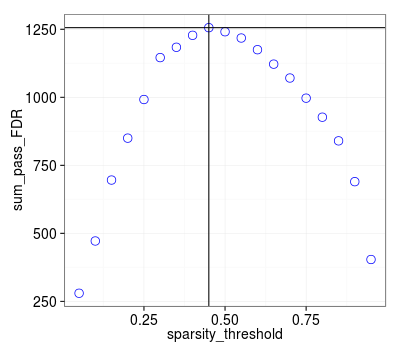

In [24]:
%%R -w 400 -h 350
d = combined_l2fc %.% 
    group_by(sparsity_threshold) %.%
    summarize(sum_pass_FDR = sum(padj < 0.10))

p = ggplot(d, aes(x = sparsity_threshold, y = sum_pass_FDR))

p = p + geom_point(size = 4, shape = 21, color = "blue")

p = p + geom_vline(x = 0.45)

p = p + geom_hline(y = max(d$sum_pass_FDR))

p = p + theme_bw()
    
p = p + theme(axis.text = element_text(size = 14),
              axis.title = element_text(size = 14))

p

### Make dataframe that will be used for log2 fold change figures

In [27]:
%%R
write.table(combined_l2fc[zapsmall(combined_l2fc$sparsity_threshold) - 0.45 == 0,], 
            file = "/var/seq_data/priming_exp/data/l2fc_table.csv",
            row.names = FALSE,
            sep = ",")

In [28]:
!head /var/seq_data/priming_exp/data/l2fc_table.csv | cut -c1-100

"sparsity_threshold","Day","Treatment","OTU","log2FoldChange","p","Rank1","Rank2","Rank3","Rank4","R
0.45,14,"13CC","OTU.4204",-0.205888181069775,0.999965745681036,"Bacteria","Acidobacteria","DA023",NA
0.45,14,"13CC","OTU.467",-0.304023920635686,0.999997986280081,"Bacteria","Acidobacteria","DA023","un
0.45,14,"13CC","OTU.905",0.0837289535801584,0.976367905132783,"Bacteria","Acidobacteria","DA023","un
0.45,14,"13CC","OTU.7253",0.128030790581088,0.965795231598108,"Bacteria","Acidobacteria","DA023","un
0.45,14,"13CC","OTU.67",-0.520848405641092,0.999999054342696,"Bacteria","Acidobacteria","DA023","unc
0.45,14,"13CC","OTU.4907",0.143864492029812,0.999423832655062,"Bacteria","Acidobacteria","DA023","un
0.45,14,"13CC","OTU.7898",0.337550167874079,0.964540955529558,"Bacteria","Acidobacteria","DA023","un
0.45,14,"13CC","OTU.125",-0.177871081617135,0.999999507409887,"Bacteria","Acidobacteria","DA023","un
0.45,14,"13CC","OTU.3516",0.197074807132437,0.900455822168823,"Bacteria","Acidobacteria","D